In [2]:
! pip install requests


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import requests
import json
import time
import random
import os
from datetime import datetime

MAX_PAGES_TO_SCRAPE = 100  
RESULTS_PER_PAGE = 100     

LISTING_API_BASE = "https://api.bdjobs.com/Jobs/api/JobSearch/GetJobSearch?Icat=&industry=&category=&org=&jobNature=&Fcat=&location=&Qot=&jobType=&jobLevel=&postedWithin=&deadline=&keyword=&pg={}&qAge=&Salary=&experience=&gender=&MExp=&genderB=&MPostings=&MCat=&version=&rpp={}&Newspaper=&armyp=&QDisablePerson=&pwd=&workplace=&facilitiesForPWD=&SaveFilterList=&UserFilterName=&HUserFilterName=&earlyJobAccess=&isPro=0&ToggleJobs=true&isFresher=false"
DETAILS_API_URL = "https://gateway.bdjobs.com/jobapply/api/JobSubsystem/Job-Details"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Origin": "https://bdjobs.com",
    "Referer": "https://bdjobs.com/"
}

FILENAME = "Realtime_Jobs_Data.json"

def get_delay():
    return random.uniform(2.0, 4.0)

def fetch_job_details(job_id):
    params = {"jobId": job_id, "ln": "1", "IsCorporate": "false"}
    try:
        time.sleep(get_delay()) 
        response = requests.get(DETAILS_API_URL, params=params, headers=HEADERS, timeout=15)
        
        if response.status_code == 200:
            resp_json = response.json()
            if 'data' in resp_json:
                inner_data = resp_json['data']
                if isinstance(inner_data, list):
                    return inner_data[0] if len(inner_data) > 0 else None
                elif isinstance(inner_data, dict):
                    return inner_data
            return None
        elif response.status_code == 429:
            print("Too fast! Server asked to slow down. Pausing for 60s...")
            time.sleep(60)
            
    except Exception as e:
        print(f"Error fetching {job_id}: {e}")
    return None

def run_full_scraper():
    all_jobs_data = []
    existing_ids = set()

    # LOAD EXISTING DATABASE
    if os.path.exists(FILENAME):
        try:
            print(f"Loading existing database: {FILENAME}")
            with open(FILENAME, 'r', encoding='utf-8') as f:
                all_jobs_data = json.load(f)
                
                # Memorize IDs (PascalCase & camelCase support)
                for job in all_jobs_data:
                    jid = job.get('JobId') or job.get('Jobid') or job.get('jobId')
                    if jid:
                        existing_ids.add(str(jid))
                        
            print(f"Loaded & Memorized {len(existing_ids)} existing Job IDs.")
            
        except Exception as e:
            print(f"Error loading file: {e}. Starting fresh.")
            all_jobs_data = []
            existing_ids = set()
    else:
        print("Starting fresh (No database found).")

    page = 1
    total_new_jobs = 0
    
    print(f"STARTING FULL SCRAPE at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Target: Up to {MAX_PAGES_TO_SCRAPE} Pages.")
    print("------------------------------------------------")
    
    while page <= MAX_PAGES_TO_SCRAPE:
        list_url = LISTING_API_BASE.format(page, RESULTS_PER_PAGE)
        print(f"\n--- Processing Page {page} ---")
        
        try:
            resp = requests.get(list_url, headers=HEADERS, timeout=20)
            
            if resp.status_code != 200:
                print(f"Listing API Error: {resp.status_code}")
                break

            data = resp.json().get('data', [])
            
            if not data:
                print("No more jobs found. Reached end of list.")
                break
            
            current_page_ids = []
            for job in data:
                jid = job.get('Jobid') or job.get('jobId')
                if jid:
                    current_page_ids.append(str(jid))
            
            print(f"Found {len(current_page_ids)} jobs on this page.")
            
            #COMPARISON & FETCH 
            skipped_count = 0
            new_on_page = 0
            
            for i, job_id in enumerate(current_page_ids):
                
                # SKIP Check
                if job_id in existing_ids:
                    skipped_count += 1
                    continue
                
                # FETCH New Job
                print(f"   [NEW] ID: {job_id}. Fetching details...")
                details = fetch_job_details(job_id)
                
                if details:
                    all_jobs_data.append(details)
                    existing_ids.add(job_id)
                    new_on_page += 1
                    total_new_jobs += 1
                    
                    title = details.get('JobTitle') or details.get('jobTitle') or "Unknown"
                    print(f"   Added: {title[:40]}...")
                    
                    # Safety Save 
                    if total_new_jobs % 10 == 0:
                        with open(FILENAME, "w", encoding="utf-8") as f:
                            json.dump(all_jobs_data, f, ensure_ascii=False, indent=4)
                        print("   (Auto-saved progress)")

            print(f"   >> Summary: Skipped {skipped_count} (Old) | Added {new_on_page} (New)")
            
            if len(data) < RESULTS_PER_PAGE:
                print("This was the last page.")
                break

            page += 1
            
            if new_on_page == 0:
                print("   (All skipped, moving fast...)")
                time.sleep(1) 
            else:
                print("   (Taking a short break...)")
                time.sleep(3) 

        except Exception as e:
            print(f"Critical Error on Page {page}: {e}")
            print("Pausing for 10 seconds before retry...")
            time.sleep(10)
    
    # Final Save
    print("Saving Final Database...")
    with open(FILENAME, "w", encoding="utf-8") as f:
        json.dump(all_jobs_data, f, ensure_ascii=False, indent=4)
        
    print(f"FULL JOB COMPLETE!")
    print(f"Total Jobs in Database: {len(all_jobs_data)}")
    print(f"New Jobs Added Today: {total_new_jobs}")

if __name__ == "__main__":
    run_full_scraper()

Loading existing database: Realtime_Jobs_Data.json
Loaded & Memorized 11121 existing Job IDs.
STARTING FULL SCRAPE at 22:46:33
Target: Up to 100 Pages.
------------------------------------------------

--- Processing Page 1 ---
Found 100 jobs on this page.
   >> Summary: Skipped 100 (Old) | Added 0 (New)
   (All skipped, moving fast...)

--- Processing Page 2 ---
Found 100 jobs on this page.
   [NEW] ID: 1456097. Fetching details...
   Added: Manager (Admin)...
   [NEW] ID: 1456087. Fetching details...
   Added: Site Engineer...
   [NEW] ID: 1456092. Fetching details...
   Added: Assistant Manager (Admin)...
   [NEW] ID: 1456082. Fetching details...
   Added: Assistant Engineer – Electrical...
   [NEW] ID: 1456091. Fetching details...
   Added: Security Officer...
   [NEW] ID: 1456090. Fetching details...
   Added: Marketing Officer...
   [NEW] ID: 1456089. Fetching details...
   Added: Audit Officer...
   [NEW] ID: 1456088. Fetching details...
   Added: Accounts Officer / Senior Accou

# **Load The Dataset**

In [33]:
import pandas as pd
import pandas as pd
import json
import re
# import openai # if we use open api we need to import this


# Load the data
df = pd.read_json('Realtime_Jobs_Data.json')

# View the first five rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   test                              13427 non-null  int64 
 1   JobId                             13427 non-null  int64 
 2   JobFound                          13427 non-null  object
 3   error                             13427 non-null  int64 
 4   CompnayName                       13427 non-null  object
 5   JobTitle                          13427 non-null  object
 6   PostedOn                          13427 non-null  object
 7   Deadline                          13427 non-null  object
 8   DeadlineDB                        13427 non-null  object
 9   JobVacancies                      13427 non-null  object
 10  JobDescription                    13427 non-null  object
 11  JobNature                         13427 non-null  object
 12  JobWorkPlace      

# **Feature Selection**

In [34]:
# List of Columns to KEEP (Important Features)
keep_columns = [
    # Identity & Category
    'JobId', 'CompnayName', 'CompanyID', 'CategoryID',  # CategoryID rakha hoyeche
    
    # Core Job Info (Title, Desc, Status)
    'JobTitle', 'JobDescription', 'JobNature', 'JobWorkPlace', 
    'PostedOn', 'Deadline', 'JobVacancies',
    
    # Matching Features (Location, Edu, Skills, Experience)
    'JobLocation',            # Raw location (LLM pipeline e dhukbe)
    'EducationRequirements',  # Raw education (LLM pipeline e dhukbe)
    'SkillsRequired', 'SuggestedSkills',
    'experience', 'Age', 'Gender',
    
    # Salary Info
    'JobSalaryMinSalary', 'JobSalaryMaxSalary', 'JobSalaryRange',
    
    # Application & Company Details
    'ApplyURL', 'ApplyEmail', 'ApplyInstruction',
    'CompanyWeb', 'CompanyAddress', 'CompanyBusiness',
    'JobOtherBenifits', 'JobSource','OnlineApply',
]

# Create new DataFrame with ONLY selected columns
# 'df' holo tomar original dataframe name
df_selected = df[keep_columns].copy()
df = df_selected
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   JobId                  13427 non-null  int64 
 1   CompnayName            13427 non-null  object
 2   CompanyID              13427 non-null  int64 
 3   CategoryID             13427 non-null  int64 
 4   JobTitle               13427 non-null  object
 5   JobDescription         13427 non-null  object
 6   JobNature              13427 non-null  object
 7   JobWorkPlace           13427 non-null  object
 8   PostedOn               13427 non-null  object
 9   Deadline               13427 non-null  object
 10  JobVacancies           13427 non-null  object
 11  JobLocation            13427 non-null  object
 12  EducationRequirements  13427 non-null  object
 13  SkillsRequired         13427 non-null  object
 14  SuggestedSkills        13427 non-null  object
 15  experience         

# **Data Sanitation Function**

In [35]:
def sanitize_data(df):
    """
    Ei function-ti column gulo ke snake_case-e convert korbe 
    ebong ID column gulo ke string format-e niye ashbe.
    """
    # Full Mapping for all 29 selected features
    rename_map = {
        'JobId': 'job_id',
        'CompnayName': 'company_name',
        'CompanyID': 'company_id',
        'CategoryID': 'category_id',
        'JobTitle': 'job_title',
        'JobDescription': 'job_description',
        'JobNature': 'job_type',
        'JobWorkPlace': 'work_place',
        'PostedOn': 'posted_on',
        'Deadline': 'deadline',
        'JobVacancies': 'vacancies',
        'JobLocation': 'raw_location',
        'EducationRequirements': 'raw_education',
        'SkillsRequired': 'skills',
        'SuggestedSkills': 'suggested_skills',
        'experience': 'experience',
        'Age': 'age',
        'Gender': 'gender',
        'JobSalaryMinSalary': 'min_salary',
        'JobSalaryMaxSalary': 'max_salary',
        'JobSalaryRange': 'salary_range',
        'ApplyURL': 'apply_url',
        'ApplyEmail': 'apply_email',
        'ApplyInstruction': 'apply_instruction',
        'CompanyWeb': 'company_web',
        'CompanyAddress': 'company_address',
        'CompanyBusiness': 'company_business',
        'JobOtherBenifits': 'job_benefits',
        'JobSource': 'job_source',
        'OnlineApply': 'online_apply'
    }
    
    # Column rename kora
    df_clean = df.rename(columns=rename_map)
    
    # ID column gulo ke string-e convert kora (Scientific notation avoid korar jonno)
    id_columns = ['job_id', 'company_id', 'category_id']
    for col in id_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)
            
    return df_clean



# **Apply Sanitation**

In [36]:
# Clean the dataframe
df = sanitize_data(df)
print(df.info())
# Check the new column names
print("New Column Names:", df.columns.tolist())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job_id             13427 non-null  object
 1   company_name       13427 non-null  object
 2   company_id         13427 non-null  object
 3   category_id        13427 non-null  object
 4   job_title          13427 non-null  object
 5   job_description    13427 non-null  object
 6   job_type           13427 non-null  object
 7   work_place         13427 non-null  object
 8   posted_on          13427 non-null  object
 9   deadline           13427 non-null  object
 10  vacancies          13427 non-null  object
 11  raw_location       13427 non-null  object
 12  raw_education      13427 non-null  object
 13  skills             13427 non-null  object
 14  suggested_skills   13427 non-null  object
 15  experience         13427 non-null  object
 16  age                13427 non-null  objec

,job_id,company_name,company_id,category_id,job_title,job_description,job_type,work_place,posted_on,deadline,...,salary_range,apply_url,apply_email,apply_instruction,company_web,company_address,company_business,job_benefits,job_source,online_apply
0,1436370,RK Supply Ltd.,109093,8,Data Analyst / Accounts Officer,"<p><strong><span style=""color:rgb(51, 51, 51);...",Full Time,Work at office,"Dec 6, 2025","Dec 31, 2025",...,Tk. 20000 - 35000 (Monthly),,,Selected candidates for this role will be trai...,,,,,,True
1,1437042,Pridesys IT Limited,38072,8,Processor/Senior Processor,<ul><li>Review property preservation work orde...,Full Time,Work at office,"Dec 6, 2025","Jan 5, 2026",...,Negotiable,,,,,"Level-11, Vision 2021 Tower-1, Software Techno...",Pridesys IT Ltd. own developed ERP product for...,<ul><li>Salary Review: Yearly</li><li>Festival...,,True
2,1437039,Aalok Healthcare & Hospital,92299,11,Assistant Manager (Customer Care / Admin),<h3>Shift Management and Operational Leadershi...,Full Time,Work at office,"Dec 6, 2025","Dec 26, 2025",...,--,,Send your CV to the given email hr.aalok@gmail...,<p>Read before Apply and email us mention as E...,https://www.aalokhealthcare.com/,"Corporate Office: House# 3, Road # 4, Block # ...",,<ul><li>Provident fund</li><li>Salary Review: ...,,True


# **Processing Functions and Main Pipeline Execution**

In [37]:
import json
import re
import pandas as pd

# --- Functions (Logic Same as Before) ---

def get_llm_extraction_prompt(location_text, education_text):
    clean_edu = re.sub('<[^<]+?>', ' ', str(education_text)).strip()
    clean_loc = str(location_text).strip()
    
    prompt = f"""
    Extract structured data.
    Input: Location: "{clean_loc}", Education: "{clean_edu}"
    Output JSON: {{ "location": {{ "district": "...", "fine_grained": "..." }}, "education": [ {{ "level": "...", "subject": "..." }} ] }}
    """
    return prompt

def call_llm_api(prompt, raw_loc, raw_edu):
    """
    Simulated Logic for ALL rows.
    """
    # 1. Location Logic
    raw_loc_lower = str(raw_loc).lower().strip()
    if "anywhere in bangladesh" in raw_loc_lower:
        dist, fine = "Anywhere in Bangladesh", "none"
    elif "(" in str(raw_loc):
        parts = re.findall(r"([^(]+)\s*\(([^)]+)\)", str(raw_loc))
        if parts:
            dist, fine = parts[0][0].strip(), parts[0][1].strip()
        else:
            dist, fine = raw_loc, "none"
    else:
        dist, fine = raw_loc, "none"

    # 2. Education Logic
    clean_edu = re.sub('<[^<]+?>', ' ', str(raw_edu)).lower()
    edu_list = []
    
    # Simple keyword matching for simulation
    if any(x in clean_edu for x in ['cse', 'computer science', 'it', 'software']):
        edu_list.append({"level": "Bachelor", "subject": "Computer Science"})
    elif any(x in clean_edu for x in ['bba', 'mba', 'marketing', 'finance']):
        edu_list.append({"level": "Bachelor", "subject": "Business Administration"})
    elif 'diploma' in clean_edu:
        edu_list.append({"level": "Diploma", "subject": "Engineering"})
    
    if not edu_list:
        edu_list.append({"level": "Bachelor", "subject": "Any"})

    return json.dumps({
        "location": { "district": dist, "fine_grained": fine },
        "education": edu_list
    })

# --- Main Execution (Full Dataset) ---

processed_data = []
total_rows = len(df)
print(f"Starting processing for ALL {total_rows} rows...")

# Loop through ALL rows (removed .head())
for index, row in df.iterrows():
    
    raw_loc = row.get('raw_location', '')
    raw_edu = row.get('raw_education', '')
    
    prompt = get_llm_extraction_prompt(raw_loc, raw_edu)
    
    try:
        llm_response_str = call_llm_api(prompt, raw_loc, raw_edu)
        llm_data = json.loads(llm_response_str)
        
        row_dict = row.to_dict()
        
        # Location
        row_dict['district'] = llm_data.get('location', {}).get('district')
        row_dict['fine_grained_location'] = llm_data.get('location', {}).get('fine_grained')
        
        # Education
        edu_data = llm_data.get('education', [])
        row_dict['processed_education'] = edu_data
        
        if edu_data:
            row_dict['education_level'] = edu_data[0].get('level')
            row_dict['education_subject'] = edu_data[0].get('subject')
        else:
            row_dict['education_level'] = "Any"
            row_dict['education_subject'] = "Any"
        
        processed_data.append(row_dict)
        
    except Exception as e:
        print(f"Error at row {index}: {e}")
        continue
    
    # Progress Update (prottek 100 row por por status dekhabe)
    if index % 100 == 0:
        print(f"Processed {index}/{total_rows} rows...", end='\r')

# Update the main DataFrame with processed data
df_final = pd.DataFrame(processed_data)

print(f"\nProcessing Complete! Total rows: {len(df_final)}")

# Show first few rows to verify
display_cols = ['job_id', 'district', 'fine_grained_location', 'education_level', 'education_subject']
print(df_final[display_cols].head())

Starting processing for ALL 13427 rows...
Processed 13400/13427 rows...
Processing Complete! Total rows: 13427
    job_id                district fine_grained_location education_level  \
0  1436370                   Dhaka                Banani        Bachelor   
1  1437042                   Dhaka          Kawran Bazar        Bachelor   
2  1437039                   Dhaka                Mirpur        Bachelor   
3  1436999  Anywhere in Bangladesh                  none        Bachelor   
4  1437032  Anywhere in Bangladesh                  none        Bachelor   

  education_subject  
0  Computer Science  
1               Any  
2               Any  
3               Any  
4               Any  


In [38]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_id                 13427 non-null  object
 1   company_name           13427 non-null  object
 2   company_id             13427 non-null  object
 3   category_id            13427 non-null  object
 4   job_title              13427 non-null  object
 5   job_description        13427 non-null  object
 6   job_type               13427 non-null  object
 7   work_place             13427 non-null  object
 8   posted_on              13427 non-null  object
 9   deadline               13427 non-null  object
 10  vacancies              13427 non-null  object
 11  raw_location           13427 non-null  object
 12  raw_education          13427 non-null  object
 13  skills                 13427 non-null  object
 14  suggested_skills       13427 non-null  object
 15  experience         

# **Checking For Null Values**

job_id               0
company_name         0
company_id           0
category_id          0
job_title            0
job_description      0
job_type             0
work_place           0
posted_on            0
deadline             0
vacancies            0
raw_location         0
raw_education        0
skills               0
suggested_skills     0
experience           0
age                  0
gender               0
min_salary           0
max_salary           0
salary_range         0
apply_url            0
apply_email          0
apply_instruction    0
company_web          0
company_address      0
company_business     0
job_benefits         0
job_source           0
online_apply         0
dtype: int64


<Axes: >

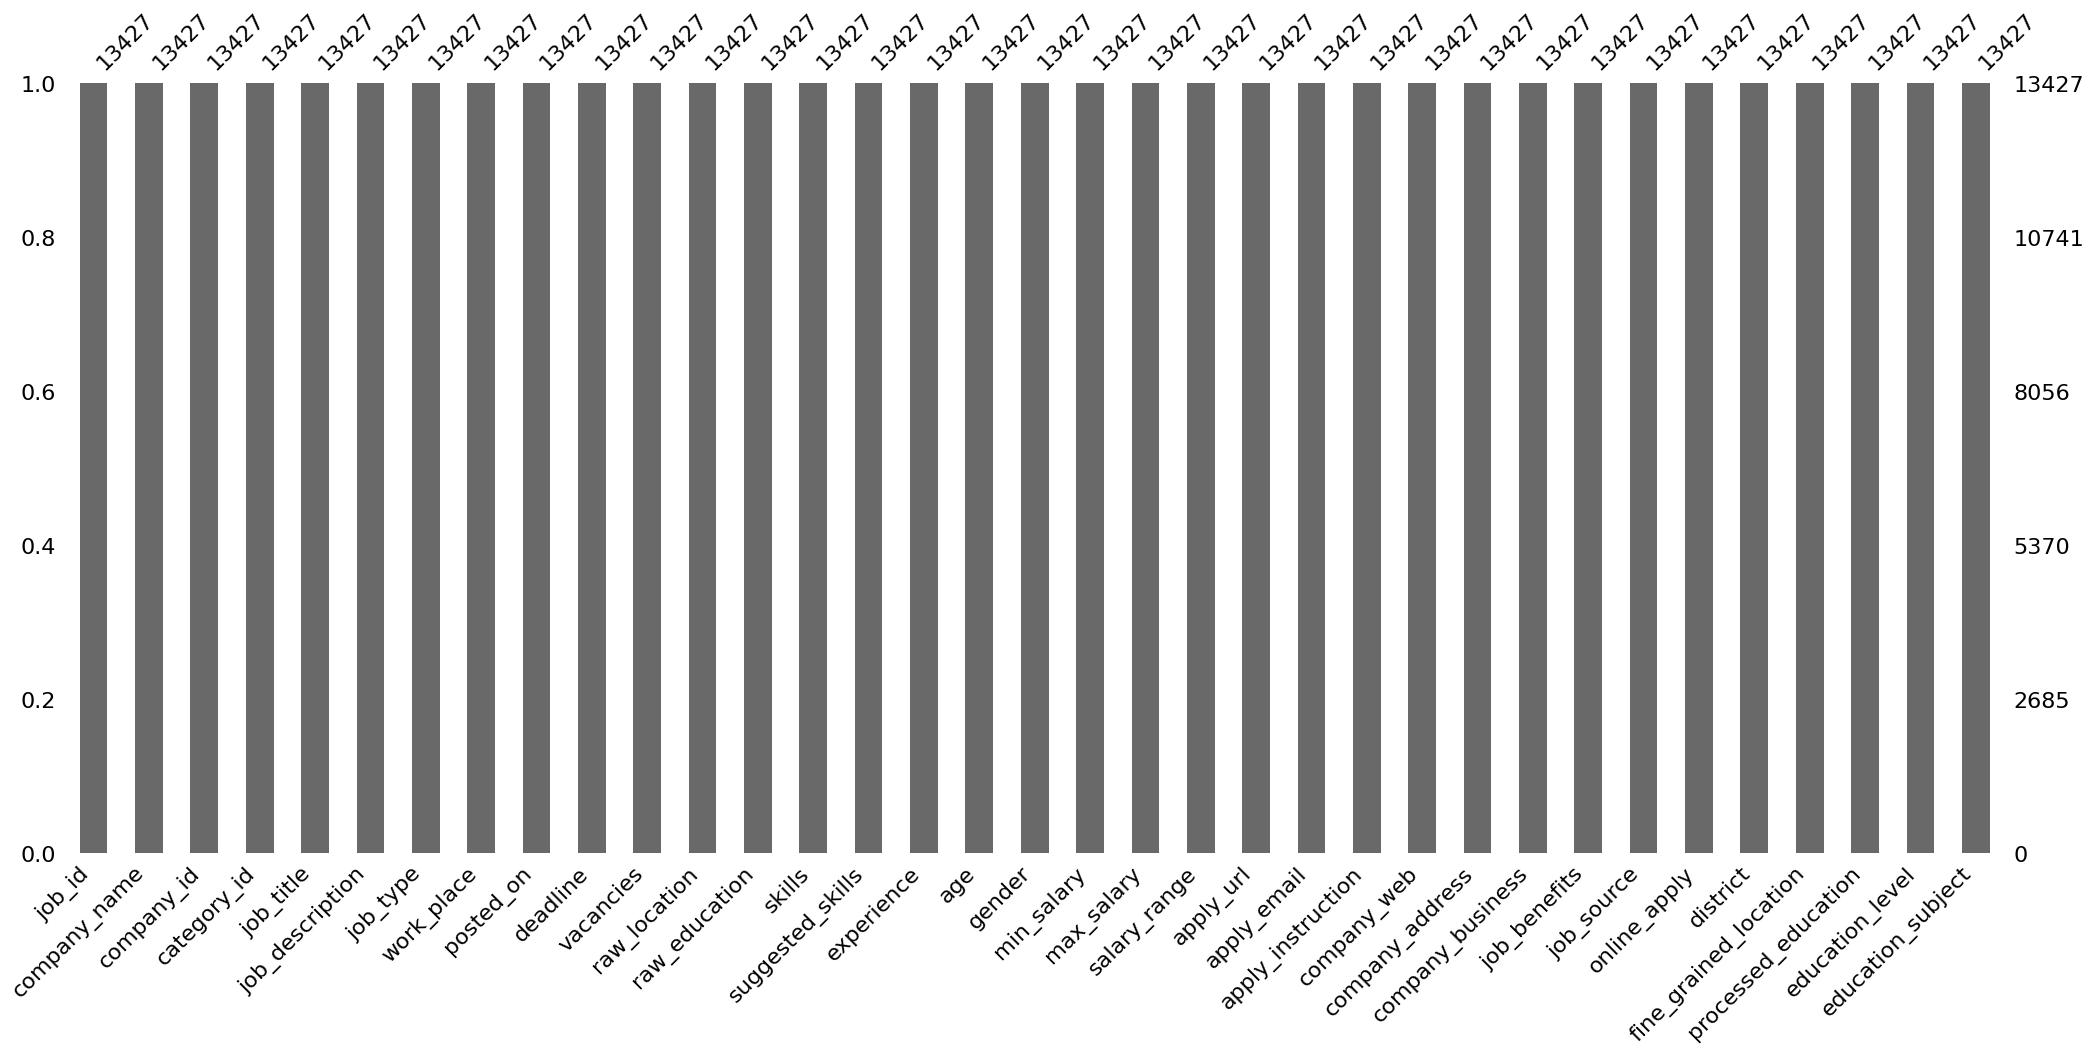

In [39]:
print(df.isnull().sum())

import missingno as msno
msno.bar(df_final)

In [40]:
# Create a summary table of all features
feature_info = pd.DataFrame({
    'Column Name': df_final.columns,
    'Data Type': df_final.dtypes,
    'Non-Null Count': df_final.count(),
    # We use .apply(lambda x: str(x)) to handle the list columns
    'Unique Values': df_final.apply(lambda x: x.map(str).nunique()), 
    'Missing Values': df_final.isnull().sum()
}).reset_index(drop=True)

# Display the whole list
print(feature_info.to_string())

              Column Name Data Type  Non-Null Count  Unique Values  Missing Values
0                  job_id    object           13427          13396               0
1            company_name    object           13427           6120               0
2              company_id    object           13427           5334               0
3             category_id    object           13427             60               0
4               job_title    object           13427          10271               0
5         job_description    object           13427          12408               0
6                job_type    object           13427             10               0
7              work_place    object           13427              4               0
8               posted_on    object           13427            180               0
9                deadline    object           13427            228               0
10              vacancies    object           13427             83               0
11  

In [27]:
!pip install beautifulsoup4
!pip install lxml


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# **The "Hidden" Null Check**

In [41]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re



# Create a copy to work on
df_clean = df_final.copy()

print(f"Original Shape: {df_clean.shape}")


Original Shape: (13427, 35)


In [42]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re

# ২. Text cleaning Function
def strip_html(text):
    if not isinstance(text, str): return text
    if '<' not in text or '>' not in text: return text
    try:
        soup = BeautifulSoup(text, "html.parser")
        clean_text = soup.get_text(separator=" ")
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        return clean_text
    except: return text

# ৩. নাম্বার এক্সট্রাকশন ফাংশন
def extract_range(text):
    if pd.isna(text) or text == "Any" or text == "":
        return None, None
    numbers = re.findall(r'\d+', str(text))
    if not numbers:
        return None, None
    nums = [int(n) for n in numbers]
    if len(nums) >= 2:
        return nums[0], nums[1]
    elif len(nums) == 1:
        return nums[0], None
    return None, None

# ৪. ক্লিনিং প্রসেস শুরু (Sanitized names use kora hoyeche)
# ---------------------------------------------------------

# HTML পরিষ্কার করা (Updated names)
html_columns = ['job_description', 'raw_education', 'job_benefits', 'apply_instruction']
for col in html_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(strip_html)

# লজিক্যাল নাল হ্যান্ডেল করা
missing_indicators = ["--", "N/A", "n/a", "Not Applicable", "[]", "", " ", "0000-00-00"]
df_clean.replace(missing_indicators, np.nan, inplace=True)

# স্যালারি এবং ভ্যাকেন্সি ঠিক করা (Updated names)
if 'min_salary' in df_clean.columns:
    df_clean['min_salary'] = df_clean['min_salary'].replace(0, np.nan)
if 'max_salary' in df_clean.columns:
    df_clean['max_salary'] = df_clean['max_salary'].replace(0, np.nan)
if 'vacancies' in df_clean.columns:
    df_clean['vacancies'] = pd.to_numeric(df_clean['vacancies'], errors='coerce')

# ৫. বয়স (age) এবং অভিজ্ঞতা (experience) পার্স করা
# ---------------------------------------------------------

# age পার্সিং (Updated name: 'age')
if 'age' in df_clean.columns:
    print("Extracting Age Range...")
    age_data = df_clean['age'].apply(extract_range)
    df_clean['min_age'] = age_data.apply(lambda x: x[0])
    df_clean['max_age'] = age_data.apply(lambda x: x[1])

# experience পার্সিং
if 'experience' in df_clean.columns:
    print("Extracting Experience Range...")
    exp_data = df_clean['experience'].apply(extract_range)
    df_clean['min_experience'] = exp_data.apply(lambda x: x[0])
    df_clean['max_experience'] = exp_data.apply(lambda x: x[1])

# ৬. ফলাফল দেখা (Updated names for display)
# ---------------------------------------------------------
print("\n" + "="*40)
print("UPDATED CLEANING SUMMARY")
print("="*40)

# Check logic to avoid printing if columns don't exist
display_cols = ['age', 'min_age', 'max_age']
existing_display_cols = [c for c in display_cols if c in df_clean.columns]

if existing_display_cols:
    print(df_clean[existing_display_cols].head(10))

# Age column drop kora (jodi extract hoye thake)
if 'age' in df_clean.columns:
    df_clean.drop(columns=['age'], inplace=True)

print("\nCleaning Complete!")

Extracting Age Range...
Extracting Experience Range...

UPDATED CLEANING SUMMARY
                 age  min_age  max_age
0     20 to 35 years     20.0     35.0
1     20 to 35 years     20.0     35.0
2                 Na      NaN      NaN
3     22 to 40 years     22.0     40.0
4     24 to 30 years     24.0     30.0
5     25 to 38 years     25.0     38.0
6  At least 27 years     27.0      NaN
7                 Na      NaN      NaN
8  At least 28 years     28.0      NaN
9     20 to 35 years     20.0     35.0

Cleaning Complete!


In [43]:
df_clean.head()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_id                 13427 non-null  object 
 1   company_name           13427 non-null  object 
 2   company_id             13427 non-null  object 
 3   category_id            13427 non-null  object 
 4   job_title              13427 non-null  object 
 5   job_description        12910 non-null  object 
 6   job_type               13427 non-null  object 
 7   work_place             10455 non-null  object 
 8   posted_on              13427 non-null  object 
 9   deadline               13427 non-null  object 
 10  vacancies              8697 non-null   float64
 11  raw_location           13427 non-null  object 
 12  raw_education          12330 non-null  object 
 13  skills                 6652 non-null   object 
 14  suggested_skills       10398 non-null  object 
 15  ex

# **Word Counts and Common Phrases**

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2489 (\N{BENGALI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2453 (\N{BENGALI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) 

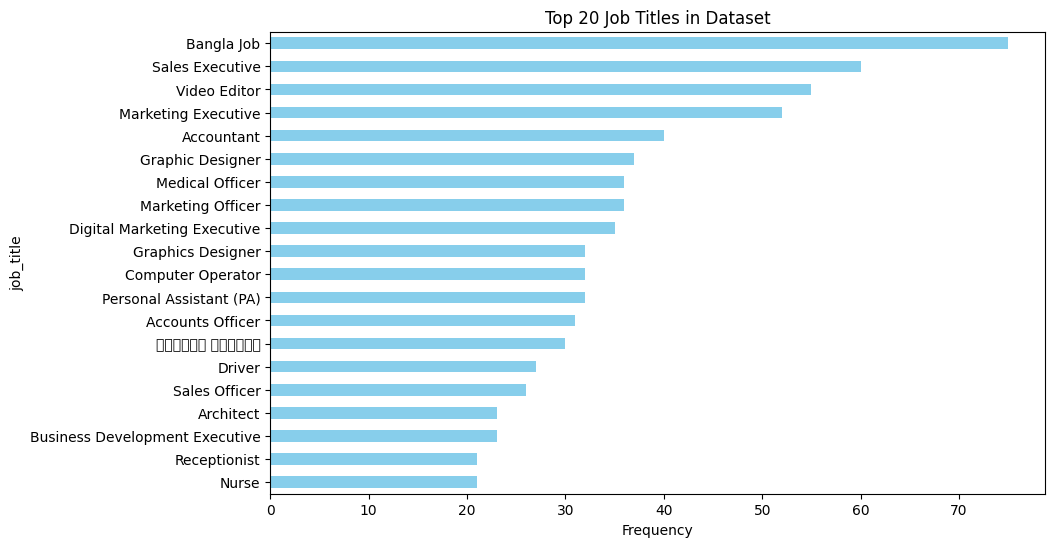

KeyError: 'SkillsRequired'

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# 1. Visualize Top Job Titles
plt.figure(figsize=(10, 6))
df_clean['job_title'].value_counts().head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Job Titles in Dataset')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.show()

# 2. Word Cloud for Skills (Crucial for Matching)
# We join all text in the SkillsRequired column
skills_text = " ".join(df_final['SkillsRequired'].fillna('').astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis', max_words=100).generate(skills_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Skills Required')
plt.show()

# **Filter Distribution**

C:\Users\User\AppData\Local\Temp\ipykernel_2936\3476858371.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='JobNature', palette='Set2')


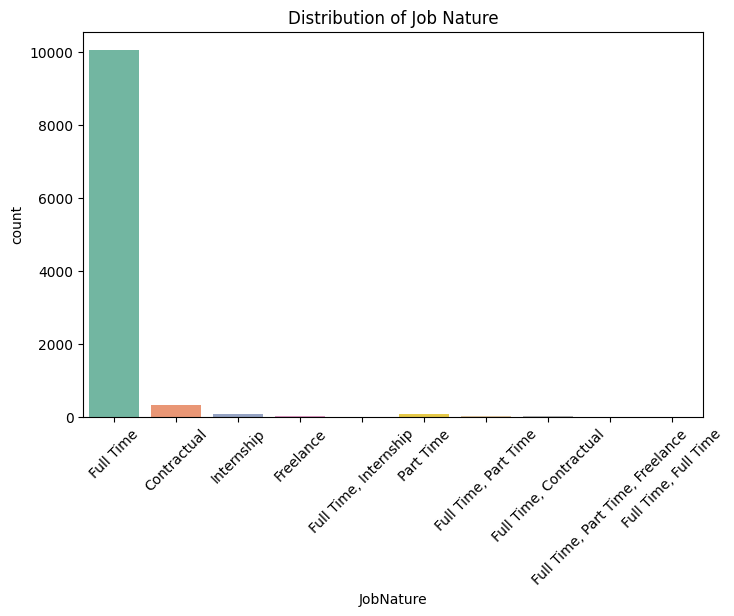

Salary Disclosure Rate:
HasSalary
Hidden/Negotiable    72.528932
Disclosed            27.471068
Name: proportion, dtype: float64


In [196]:
# 3. Analyze Job Nature (Full-time, Part-time, etc.)
plt.figure(figsize=(8, 5))
sns.countplot(data=df_final, x='JobNature', palette='Set2')
plt.title('Distribution of Job Nature')
plt.xticks(rotation=45)
plt.show()

# 4. Analyze Salary Presence
# Since a bot needs to answer "What is the salary?", check how many records have it
df_final['HasSalary'] = df_final['JobSalaryMaxSalary'].apply(lambda x: 'Disclosed' if x > 0 else 'Hidden/Negotiable')
print("Salary Disclosure Rate:")
print(df_final['HasSalary'].value_counts(normalize=True) * 100)

# **Salary Distribution**

C:\Users\User\AppData\Local\Temp\ipykernel_2936\403398488.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['JobSalaryMinSalary'], shade=True, label='Min Salary', color="blue")
C:\Users\User\AppData\Local\Temp\ipykernel_2936\403398488.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['JobSalaryMaxSalary'], shade=True, label='Max Salary', color="green")


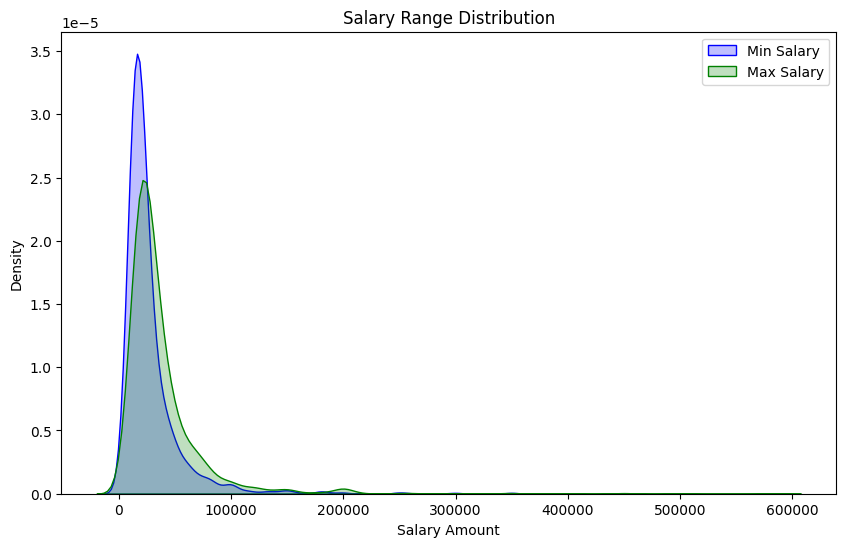

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['JobSalaryMinSalary'], shade=True, label='Min Salary', color="blue")
sns.kdeplot(df_final['JobSalaryMaxSalary'], shade=True, label='Max Salary', color="green")
plt.title('Salary Range Distribution')
plt.xlabel('Salary Amount')
plt.ylabel('Density')
plt.legend()
plt.savefig('salary_distribution.png')

# **Top 20 Job Locations**

In [198]:
unique_locations = df['JobLocation'].unique()
print(unique_locations)
print(df['JobLocation'].nunique())

['Dhaka (Banani)' 'Dhaka (Kawran Bazar)' 'Dhaka (Mirpur)' ...
 'Brahmanbaria, Chattogram (Chattogram Sadar), Cox`s Bazar, Cumilla, Sylhet'
 'Dhaka (Agargaon, Banani, Cantonment, Dhanmondi, Kawran Bazar, Khilkhet, Mirpur, Mohakhali, Mohammadpur, Pallabi, Uttara)'
 'Rajshahi (Rajshahi Sadar), Rangpur (Rangpur Sadar)']
1094


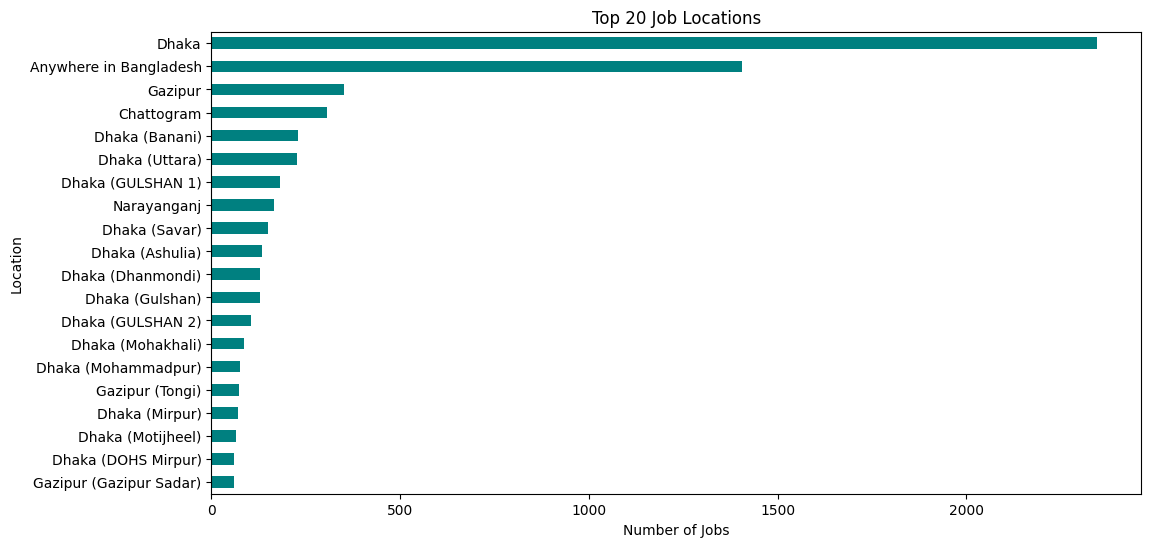

In [199]:
plt.figure(figsize=(12, 6))
df_final['JobLocation'].value_counts().head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Job Locations')
plt.xlabel('Number of Jobs')
plt.ylabel('Location')
plt.gca().invert_yaxis()
plt.savefig('top_locations.png')

# **Experiment Requirement Plot**

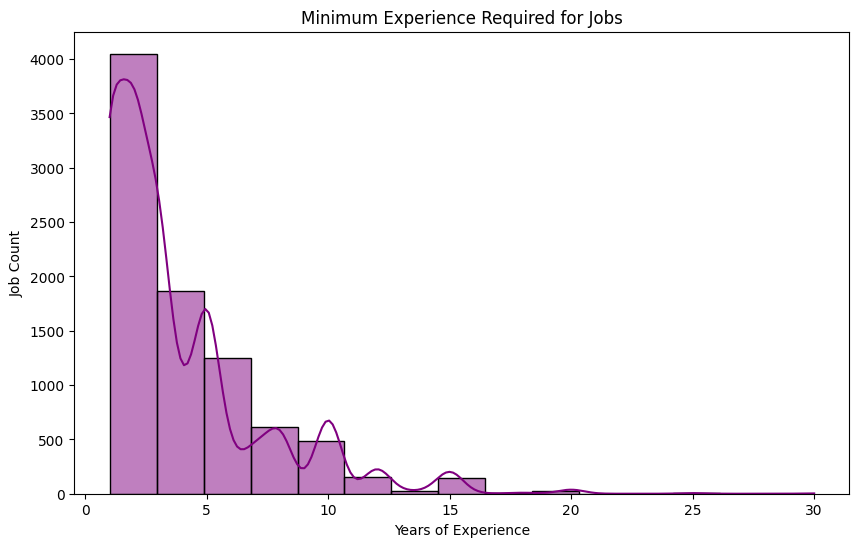

In [200]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['MinExperience'].dropna(), bins=15, color='purple', kde=True)
plt.title('Minimum Experience Required for Jobs')
plt.xlabel('Years of Experience')
plt.ylabel('Job Count')
plt.savefig('experience_distribution.png')

C:\Users\User\AppData\Local\Temp\ipykernel_2936\4050401057.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loc_salary_stats.values, y=loc_salary_stats.index, palette='magma')


Plot saved as 'salary_by_location.png'


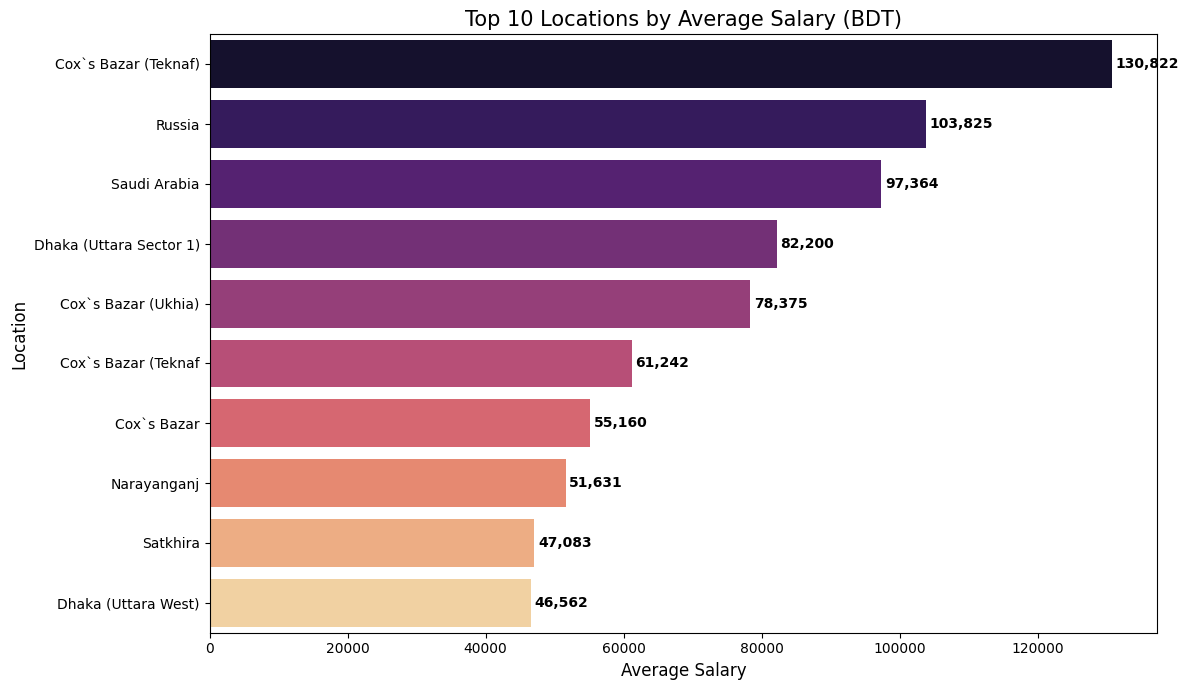

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ১. স্যালারি এবং লোকেশন ডেটা প্রসেসিং
# ---------------------------------------------------------

# Average Salary বের করা (যেখানে স্যালারি ডেটা আছে)
df_final['AvgSalary'] = (df_final['JobSalaryMinSalary'] + df_final['JobSalaryMaxSalary']) / 2

# লোকেশন ডেটা ক্লিন করা (অতিরিক্ত স্পেস বা কমা থাকলে ঠিক করা)
df_final['CleanLocation'] = df_final['JobLocation'].str.split(',').str[0].str.strip()

# যে ডেটাতে স্যালারি এবং লোকেশন দুইটাই আছে সেগুলো ফিল্টার করা
salary_loc_df = df_final.dropna(subset=['AvgSalary', 'CleanLocation'])

# ২. টপ ১০ লোকেশনের গড় স্যালারি বের করা
# ---------------------------------------------------------
# শুধু সেই লোকেশনগুলো নেওয়া যেখানে অন্তত ৫টি জব আছে (যাতে রেজাল্ট বিশ্বাসযোগ্য হয়)
loc_counts = salary_loc_df['CleanLocation'].value_counts()
top_locations = loc_counts[loc_counts >= 5].index

filtered_salary_df = salary_loc_df[salary_loc_df['CleanLocation'].isin(top_locations)]

# লোকেশন অনুযায়ী গড় স্যালারি ক্যালকুলেট করা
loc_salary_stats = filtered_salary_df.groupby('CleanLocation')['AvgSalary'].mean().sort_values(ascending=False).head(10)

# visualization
plt.figure(figsize=(12, 7))
sns.barplot(x=loc_salary_stats.values, y=loc_salary_stats.index, palette='magma')

plt.title('Top 10 Locations by Average Salary (BDT)', fontsize=15)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Location', fontsize=12)

# writing salaries values in graph
for i, v in enumerate(loc_salary_stats.values):
    plt.text(v + 500, i, f'{int(v):,}', color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('salary_by_location.png')
print("Plot saved as 'salary_by_location.png'")

# **Gender Distribution**

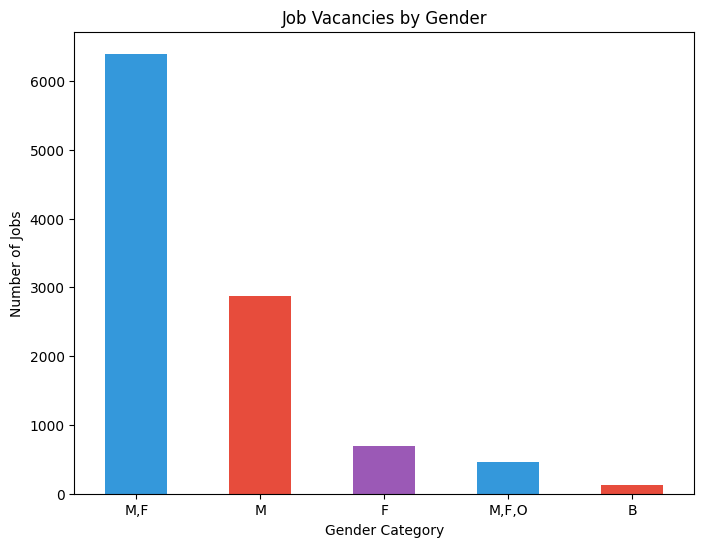

In [202]:
plt.figure(figsize=(8, 6))
df_final['Gender'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c', '#9b59b6'])
plt.title('Job Vacancies by Gender')
plt.xlabel('Gender Category')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=0)
plt.savefig('gender_distribution.png')

In [203]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10542 entries, 0 to 10541
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CompanyName            10542 non-null  object        
 1   JobTitle               10542 non-null  object        
 2   JobDescription         10150 non-null  object        
 3   SkillsRequired         5194 non-null   object        
 4   SuggestedSkills        8272 non-null   object        
 5   MinExperience          8623 non-null   float64       
 6   MaxExperience          4688 non-null   float64       
 7   JobLocation            10542 non-null  object        
 8   JobNature              10542 non-null  object        
 9   JobSalaryMinSalary     2895 non-null   float64       
 10  JobSalaryMaxSalary     2896 non-null   float64       
 11  PostedOn               10542 non-null  object        
 12  Deadline               5176 non-null   datetime64[ns]
 13  E

# **Workplace Analysis**

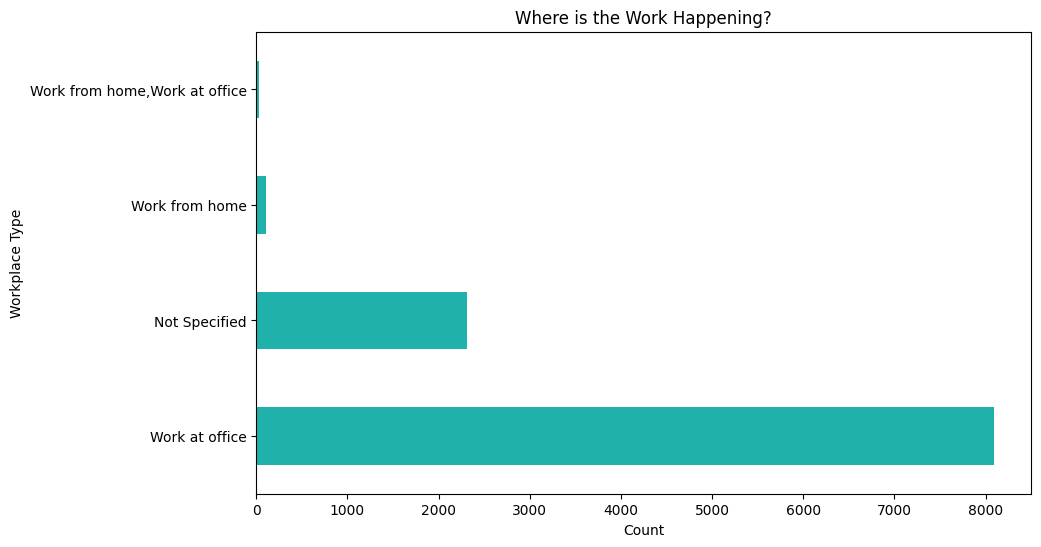

In [204]:
plt.figure(figsize=(10, 6))
df_final['JobWorkPlace'].fillna('Not Specified').value_counts().head(5).plot(kind='barh', color='lightseagreen')
plt.title('Where is the Work Happening?')
plt.xlabel('Count')
plt.ylabel('Workplace Type')
plt.savefig('workplace_type.png')

# **Top 10 Educational Requirements**

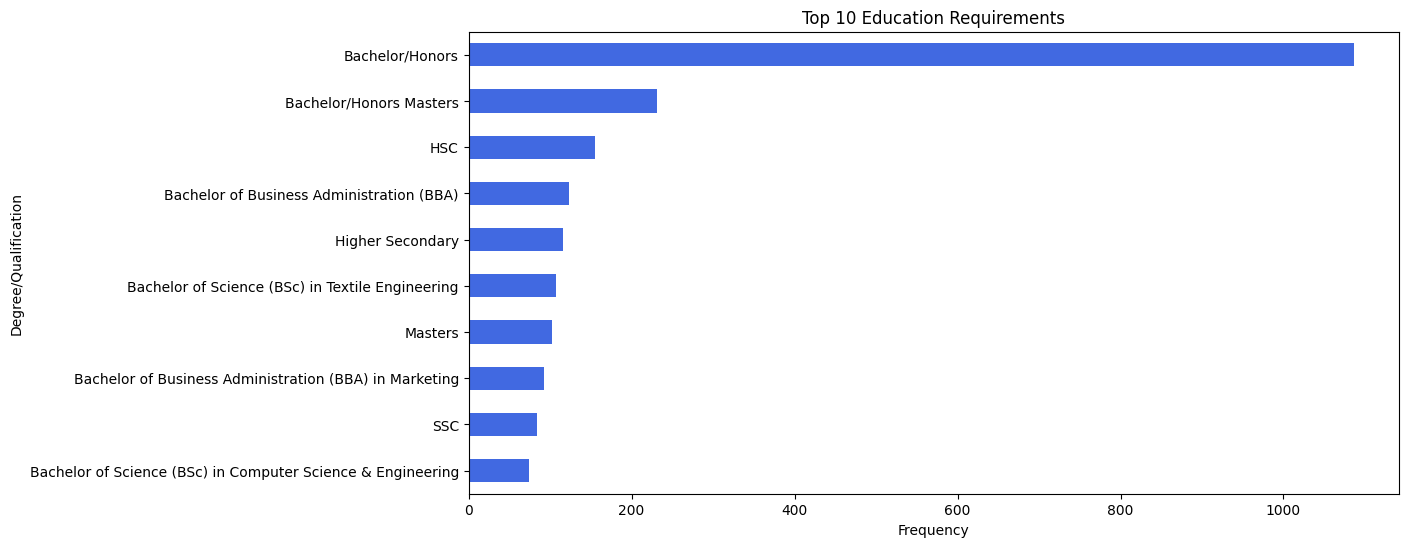

In [205]:
plt.figure(figsize=(12, 6))
df_final['EducationRequirements'].value_counts().head(10).plot(kind='barh', color='royalblue')
plt.title('Top 10 Education Requirements')
plt.xlabel('Frequency')
plt.ylabel('Degree/Qualification')
plt.gca().invert_yaxis()
plt.savefig('education_requirements.png')